# Long Short-Term Memory Network (LSTM) for Detecting AI Written Text


This LSTM model is designed to detect AI written text.

## Imports and Variable Declaration

Imported libraries to be used and variables for the model. Consolidating the variables in one area allows for easy tuning.

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import tensorflow as tf

import torchtext
from torchtext.vocab import GloVe

import matplotlib.pyplot as plt

import random

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
# Variables
input_size = 50 # embedding size
hidden_size = 100 # hidden layer size
num_layers = 1  # number of layers
num_classes = 2 # number of classes/outputs
batch_size = 100 # batch size max
num_epochs = 1 # number of epochs
learning_rate = 0.01 # learning rate
bidirectional = False # bidirectional or not
bidirect = (int(bidirectional)+1) # converting bidirectional boolean to 1 or 2 so number of layers can be multiplied by this coefficient

In [ ]:
# Downloading glove
glove = torchtext.vocab.GloVe(name ="6B", dim=input_size) # embedding size

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22632.26it/s]


## Data Processing

Retrieving the data from the respective files, spliting the text, and embbeding. The data has already been cleaned and throughly processed in another code.

In [ ]:
# Function to retrieve data from csv file
import csv
def get_data(data_type):
    return csv.reader(open("/content/" + data_type + ".csv","rt", encoding="latin-1"))


In [ ]:
# Retrieving data from the respective csv files
train = get_data("train")
val = get_data("val")
test = get_data("test")

In [ ]:
# Embbeds the text using GloVe
def get_words(glove_vector, data_type):
    output = []
    for i, line in enumerate(get_data(data_type)):
        if i == 0: # skip first line with titles of columns
            continue
        text = line[0] # column with text
        idxs = [glove_vector.stoi[w] for w in text.split() if w in glove_vector.stoi]
        if not idxs: # ignore texts without any word with an embedding
            continue
        idxs = torch.tensor(idxs)
        label = torch.tensor(int(line[1] == "1")).long()
        output.append((idxs, label))

    return output

In [ ]:
# Embbeds each dataset
train_list = get_words(glove, "train")
val_list = get_words(glove, "val")
test_list = get_words(glove, "test")

## Model

The model class, contains the specifications of what layers will be used.

In [ ]:
# RNN model
class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,num_class,num_layers,bidirectional):
    super(RNN,self).__init__()
    # look up the embeddings
    self.emb = nn.Embedding.from_pretrained(glove.vectors)
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.bidirect = 2 if bidirectional else 1
    # set up RNN
    self.rnn = nn.LSTM(input_size,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
    self.norm = nn.LayerNorm(hidden_size * self.bidirect)
    self.fc = nn.Linear(hidden_size * self.bidirect, num_classes)

  def forward(self,x):
    # look up the embeddings
    x=self.emb(x)
    # set the intial hidden states
    h0 = torch.zeros(bidirect*self.num_layers,x.size(0),self.hidden_size)
    c0 = torch.zeros(bidirect*self.num_layers,x.size(0),self.hidden_size)

    # forward propagate the RNN
    out,__ = self.rnn(x,(c0,h0))
    out = self.norm(out)
    # pass maxpool over all outputs to the classifier
    return self.fc(torch.max(out, dim=1)[0])



In [ ]:
# Set up default RNN with default values
default_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)

## Batching

The texts in the data set vary in lengths, which poses an issue for the model. To address this, texts with the same lengths are grouped together and form the batches for the model to use.

In [ ]:
# batch texts of similar lengths together
class TextBatcher:
    def __init__(self, text, batch_size=32, drop_last=False):
        # store texts by length
        self.text_by_length = {}
        for words, label in text:
            # compute the length of the text
            wlen = words.shape[0]
            # put the text in the correct key inside self.text_by_length
            if wlen not in self.text_by_length:
                self.text_by_length[wlen] = []
            self.text_by_length[wlen].append((words, label),)

        #  create a DataLoader for each set of text of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    text,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, text in self.text_by_length.items()}

    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every text length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

"""
Modified from:

Title: Tut_5_Recurrent_Neural_Networks
Author: APS360 Teaching Team
Date: 2024
Code Version: 1.0
Availability: https://q.utoronto.ca/courses/348969/files/32485421?module_item_id=5701413
"""

'\nModified from:\n\nTitle: Tut_5_Recurrent_Neural_Networks\nAuthor: APS360 Teaching Team\nDate: 2024\nCode Version: 1.0\nAvailability: https://q.utoronto.ca/courses/348969/files/32485421?module_item_id=5701413\n'

## Model Training

Calculating the accuracy of the model, training the model, and plotting the results.

In [ ]:
# calculate accuracy of model
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    # iterating through loaded data
    for text, labels in data_loader:
        output = model(text)
        # calculating predication
        pred = output.max(1, keepdim=True)[1]
        # adding up number of correct predictions
        correct += pred.eq(labels.view_as(pred)).sum().item()
        # adding up total number of texts
        total += labels.shape[0]
    if(total>0):
      return correct/total
    else:
      return 0

In [ ]:
def train_rnn_network(name, model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate):
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    if not isinstance(model, nn.Module):
        raise ValueError("Provided model is not a PyTorch neural network module")

    # iterate through epochs
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        epoch_losses = []
        # iterate through training data
        for text, labels in train_loader:
            optimizer.zero_grad()
            pred = model(text)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        # compute loss
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_epoch_loss)

        # compute accuracy
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, val_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, avg_epoch_loss, train_acc[-1], valid_acc[-1]))

        model_path = "model_{0}_epoch{1}.pth".format(name, epoch+1)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plot training curve
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # plot accuracy curve
    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, valid_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return model

## Declare Batches

Set up the batches for the training and validation datasets

In [ ]:
train_loader = TextBatcher(train_list, batch_size=batch_size, drop_last=False)

In [ ]:
val_loader = TextBatcher(val_list, batch_size=batch_size, drop_last=False)

## Default Model

Training the model on default values. This includes using an LSTM with 1 layer, layer normalization, and max pooling. See the variables declaration section to see more details about the default results.

Epoch 1; Loss 0.155278; Train Acc 0.945564; Val Acc 0.641049
Total time elapsed: 196.46 seconds


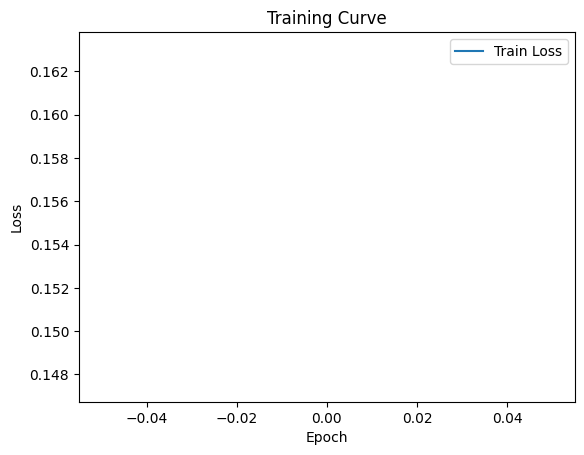

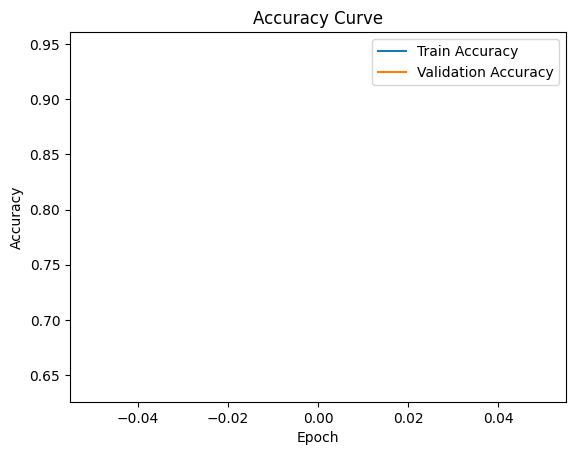

RNN(
  (emb): Embedding(400000, 50)
  (rnn): LSTM(50, 100, batch_first=True)
  (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
train_rnn_network("LSTM",default_model, train_loader, val_loader, num_epochs=1, learning_rate=learning_rate)

## Tuning Hyperparameters
Tuning learning rate, hidden units, number of layers, and dropout rate.

### Tuning by Sweeping

Validating model performace on learning rates from 0.001 to 0.05, hidden units from 50 to 200, number of layers 1 to 3, and droupout rates 0.2 to 0.5.

Testing Learning Rate: 0.001
Epoch 1; Loss 0.210897; Train Acc 0.956646; Val Acc 0.706388
Total time elapsed: 130.34 seconds


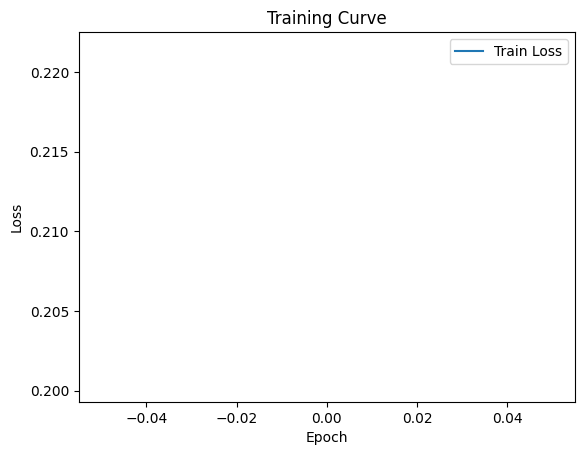

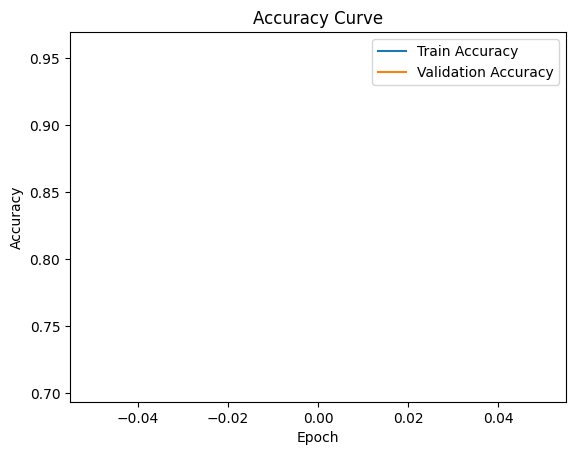



Testing Learning Rate: 0.005
Epoch 1; Loss 0.169739; Train Acc 0.840468; Val Acc 0.712510
Total time elapsed: 130.25 seconds


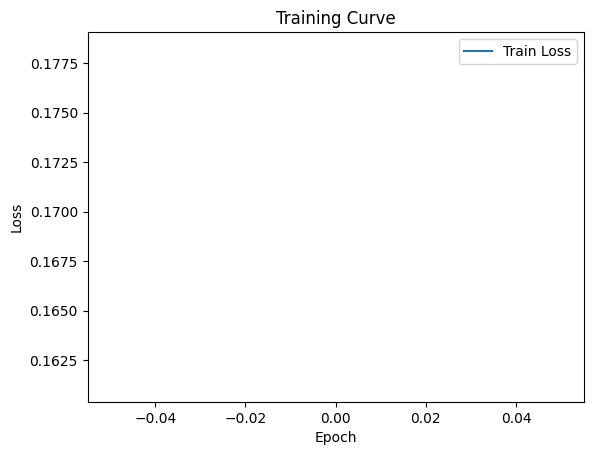

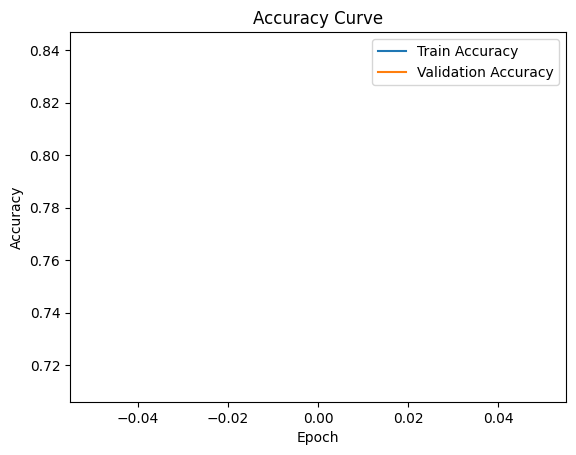



Testing Learning Rate: 0.01
Epoch 1; Loss 0.207207; Train Acc 0.965719; Val Acc 0.808828
Total time elapsed: 131.52 seconds


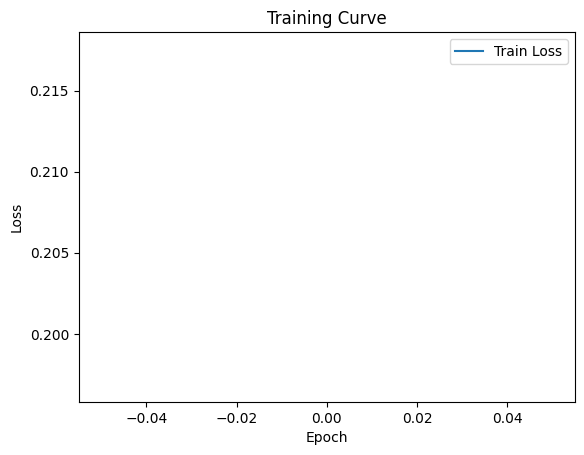

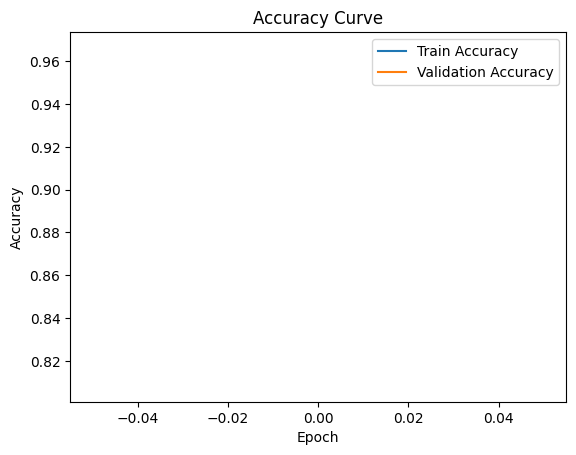



Testing Learning Rate: 0.02
Epoch 1; Loss 0.301158; Train Acc 0.894873; Val Acc 0.669195
Total time elapsed: 131.85 seconds


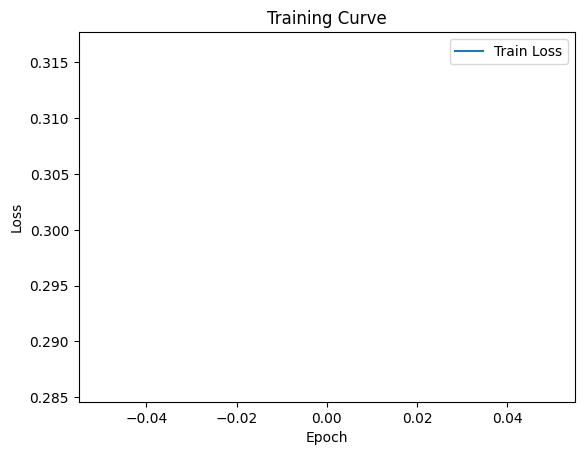

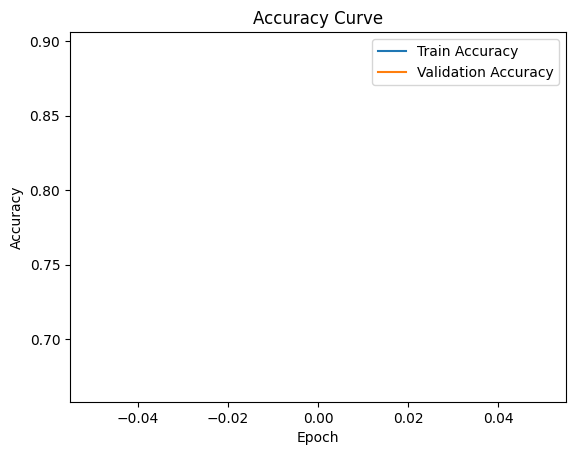



Testing Learning Rate: 0.05
Epoch 1; Loss 0.454848; Train Acc 0.712385; Val Acc 0.447501
Total time elapsed: 149.38 seconds


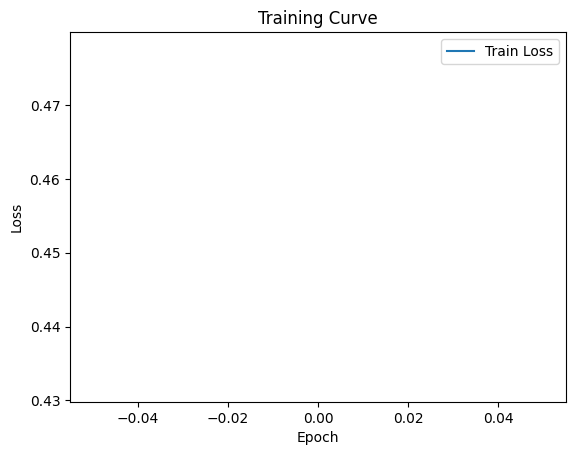

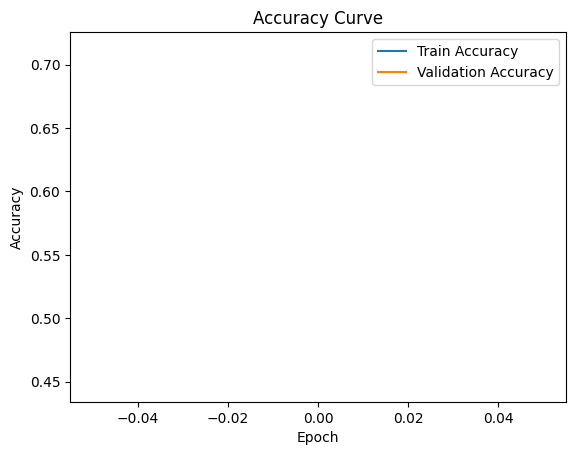

In [ ]:
def test_learning_rate(train_loader, val_loader, learning_rates, input_size, hidden_size, num_classes, num_layers, num_epochs):
    for lr in learning_rates:
        print(f"Testing Learning Rate: {lr}")
        model = RNN(input_size, hidden_size, num_classes, num_layers, bidirectional)
        train_rnn_network(str("LSTM_lr_" + str(lr)), model, train_loader, val_loader, num_epochs=1, learning_rate=lr)
        print("\n")

learning_rates = [0.001, 0.005, 0.01, 0.02, 0.05]
test_learning_rate(train_loader, val_loader, learning_rates, input_size, hidden_size, num_classes, num_layers, num_epochs)

Testing Hidden Layer Size: 50
Epoch 1; Loss 0.272202; Train Acc 0.937344; Val Acc 0.756831
Total time elapsed: 185.72 seconds


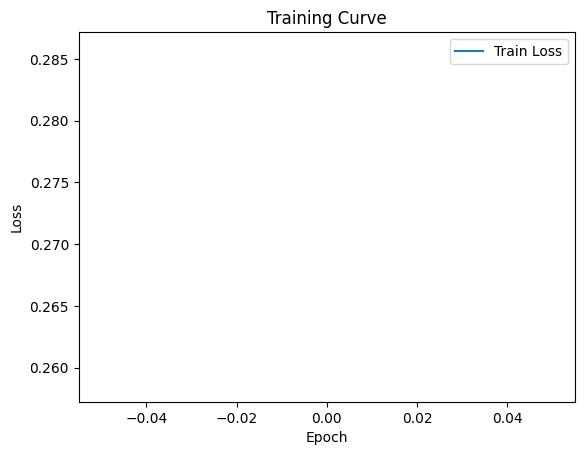

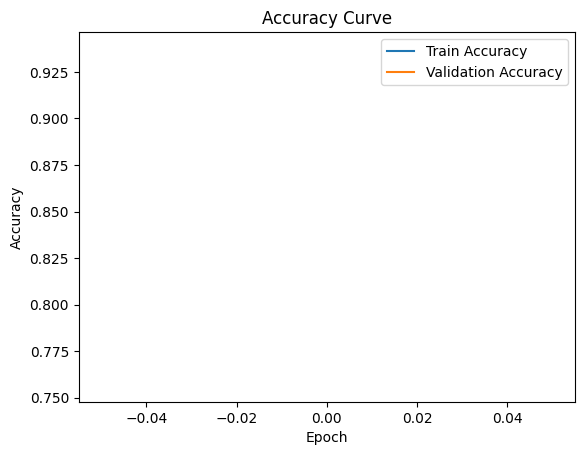

Testing Hidden Layer Size: 100
Epoch 1; Loss 0.386086; Train Acc 0.934939; Val Acc 0.693137
Total time elapsed: 372.41 seconds


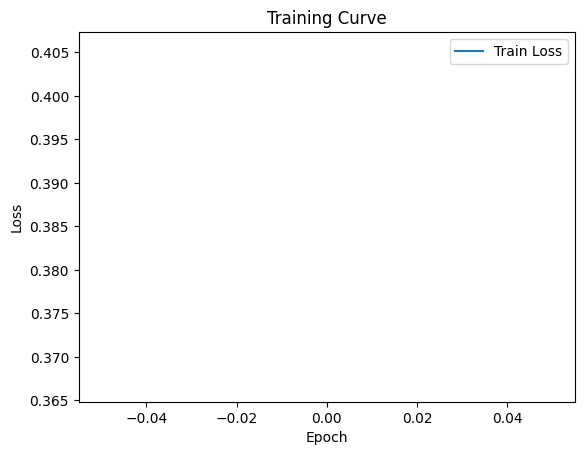

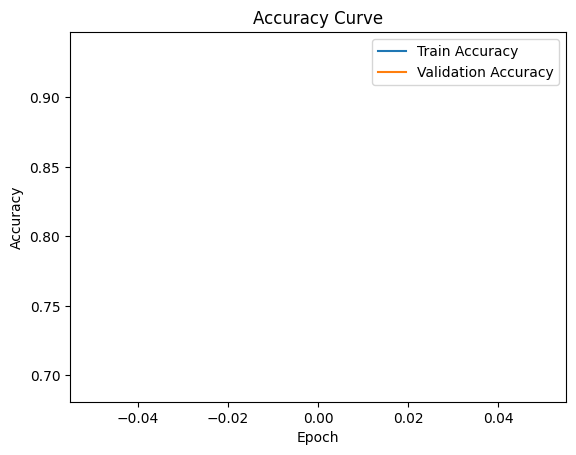

Testing Hidden Layer Size: 200
Epoch 1; Loss 0.569968; Train Acc 0.725568; Val Acc 0.499315
Total time elapsed: 867.59 seconds


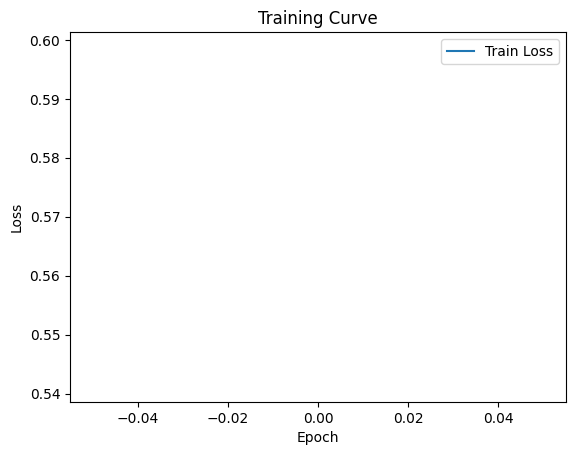

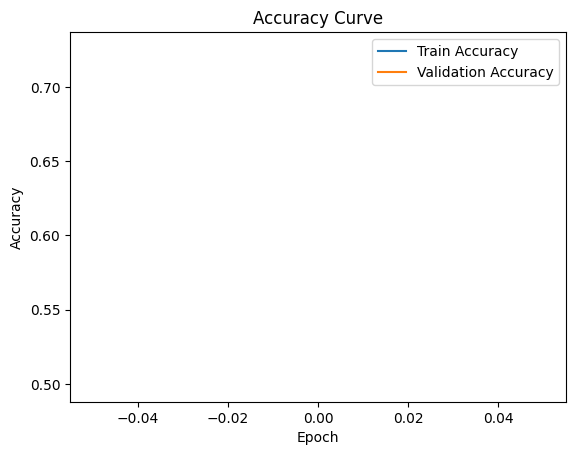

In [ ]:
def test_hidden_sizes(train_loader, val_loader, hidden_sizes):
    for hidden_size in hidden_sizes:
        print(f"Testing Hidden Layer Size: {hidden_size}")
        model = RNN(input_size, hidden_size, num_classes, num_layers, bidirectional)
        train_rnn_network("LSTM_hs_" + str(hidden_size), model, train_loader, val_loader, num_epochs, learning_rate)

hidden_sizes = [50, 100, 200]
test_hidden_sizes(train_loader, val_loader, hidden_sizes)

Testing Number of Layers: 1
Epoch 1; Loss 0.325212; Train Acc 0.911100; Val Acc 0.665174
Total time elapsed: 373.62 seconds


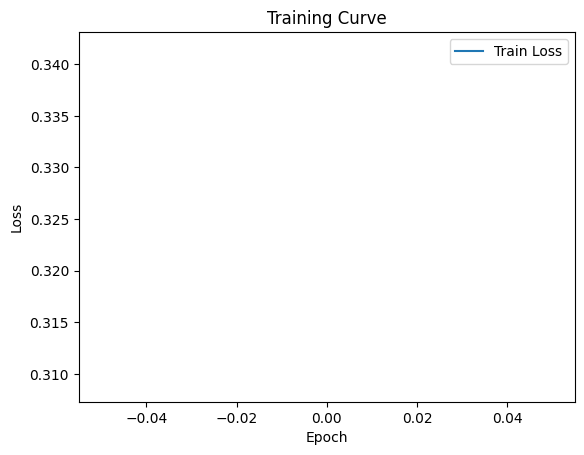

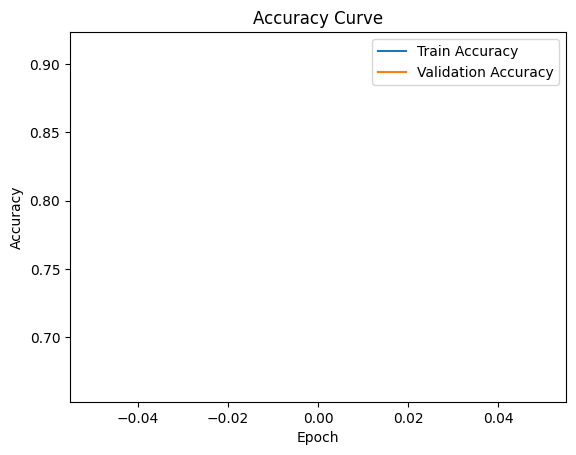

Testing Number of Layers: 2
Epoch 1; Loss 0.566728; Train Acc 0.753395; Val Acc 0.543909
Total time elapsed: 1143.02 seconds


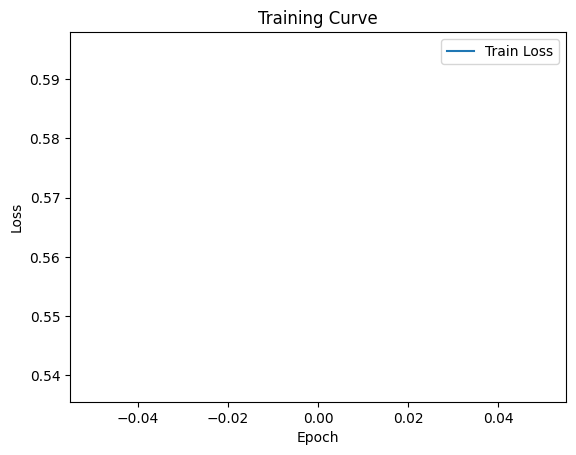

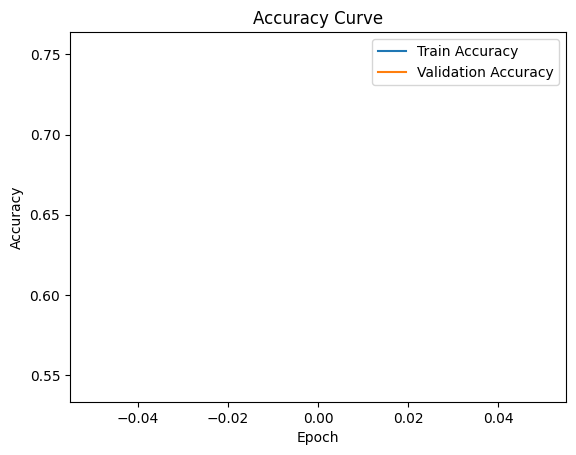

Testing Number of Layers: 3
Epoch 1; Loss 0.602766; Train Acc 0.714425; Val Acc 0.593530
Total time elapsed: 1187.79 seconds


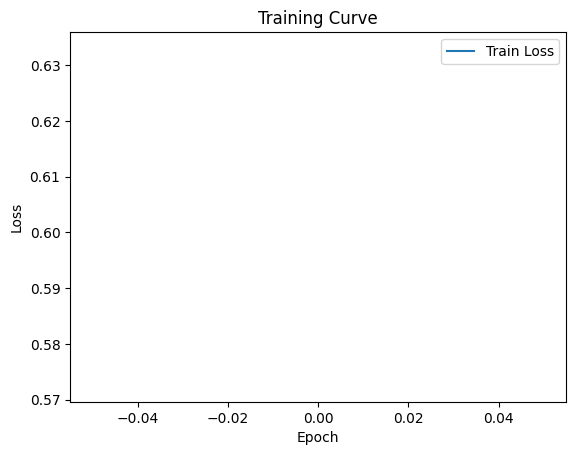

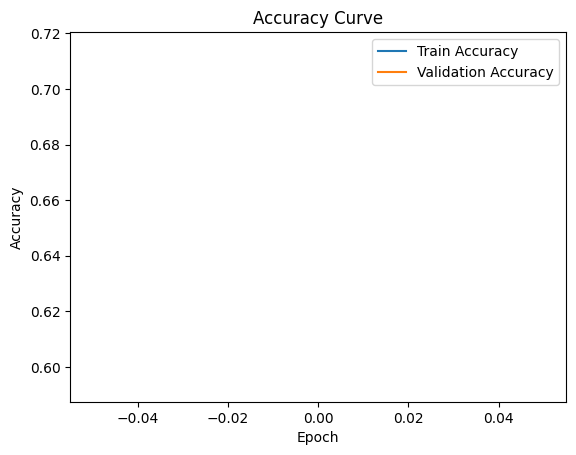

In [ ]:
def test_num_layers(train_loader, val_loader, num_layers_list):
    for num_layers in num_layers_list:
        print(f"Testing Number of Layers: {num_layers}")
        model = RNN(input_size, hidden_size, num_classes, num_layers=num_layers, bidirectional=False)
        train_rnn_network("LSTM_nl_" + str(num_layers), model, train_loader, val_loader, num_epochs=1, learning_rate=learning_rate)

num_layers_list = [1, 2, 3]
test_num_layers(train_loader, val_loader, num_layers_list)

Testing Dropout Rate: 0.2
Epoch 1; Loss 0.222133; Train Acc 0.961365; Val Acc 0.771361
Total time elapsed: 364.35 seconds


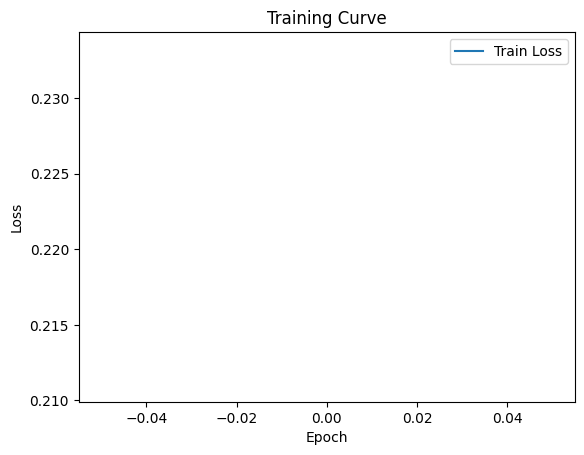

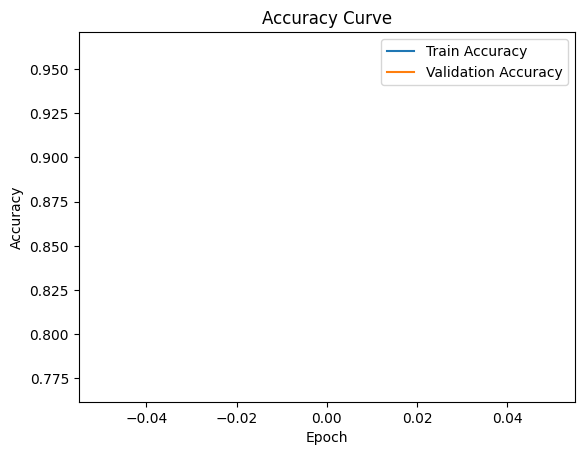



Testing Dropout Rate: 0.3
Epoch 1; Loss 0.259769; Train Acc 0.942611; Val Acc 0.717993
Total time elapsed: 362.64 seconds


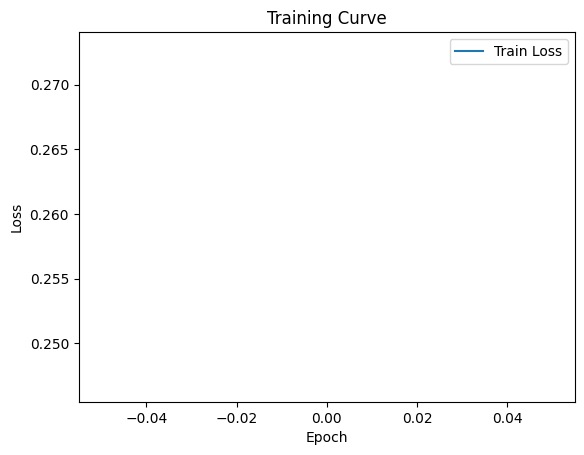

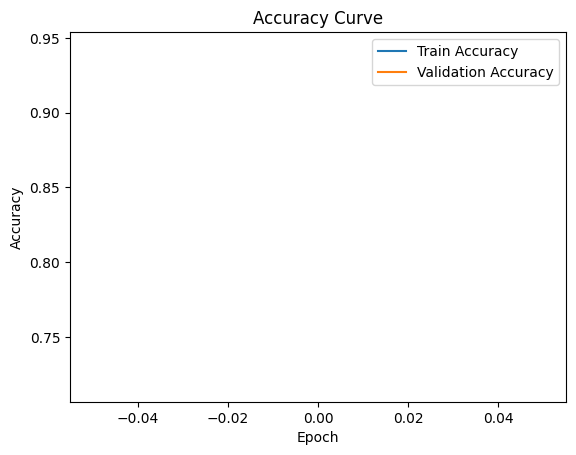



Testing Dropout Rate: 0.4
Epoch 1; Loss 0.218838; Train Acc 0.949796; Val Acc 0.769076
Total time elapsed: 368.87 seconds


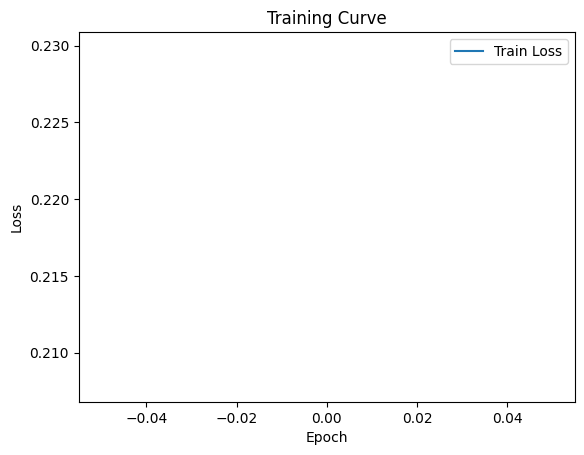

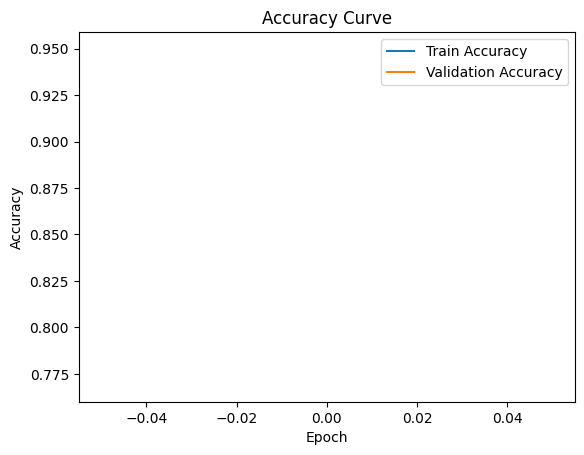



Testing Dropout Rate: 0.5
Epoch 1; Loss 0.311673; Train Acc 0.812702; Val Acc 0.649548
Total time elapsed: 364.89 seconds


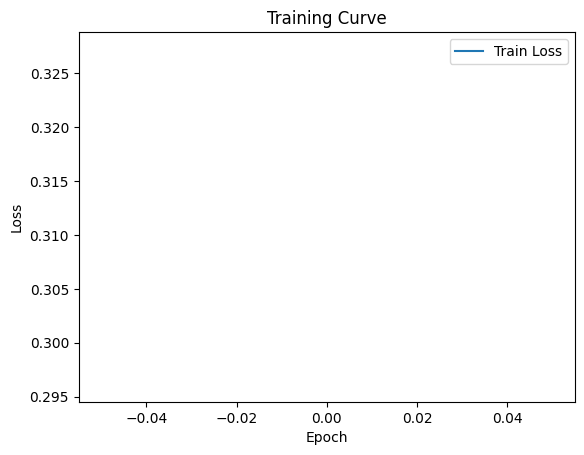

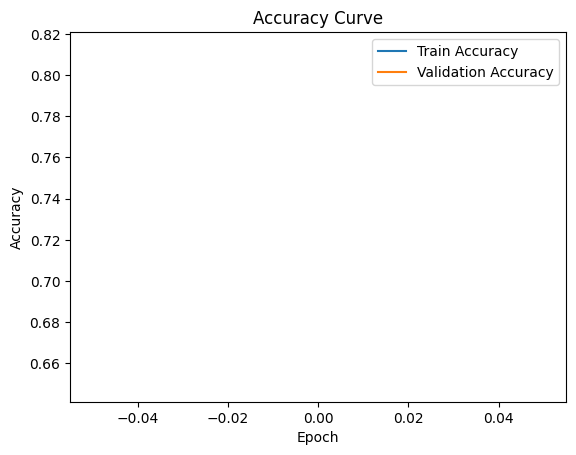

In [ ]:
def test_dropout_rate(train_loader, val_loader, dropout_rates, input_size, hidden_size, num_classes, num_layers, num_epochs, learning_rate):
    for dropout_rate in dropout_rates:
        print(f"Testing Dropout Rate: {dropout_rate}")
        model = RNN(input_size, hidden_size, num_classes, num_layers, bidirectional)
        model.dropout_rate = dropout_rate
        train_rnn_network("LSTM_dr_" + str(dropout_rate), model, train_loader, val_loader, num_epochs, learning_rate)
        print("\n")

dropout_rates = [0.2, 0.3, 0.4, 0.5]
test_dropout_rate(train_loader, val_loader, dropout_rates, input_size, hidden_size, num_classes, num_layers, num_epochs, learning_rate)


### Combination of Hyperparameter Choices

Validating the accuracy of hyperparameter combination choices.

Epoch 1; Loss 0.166341; Train Acc 0.972082; Val Acc 0.847208
Epoch 2; Loss 0.042207; Train Acc 0.985417; Val Acc 0.851503
Total time elapsed: 393.49 seconds


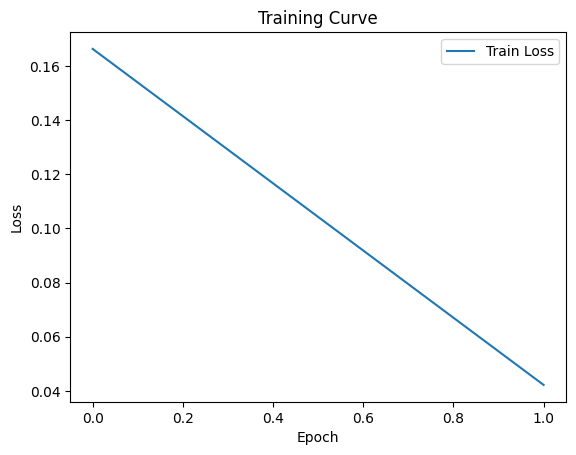

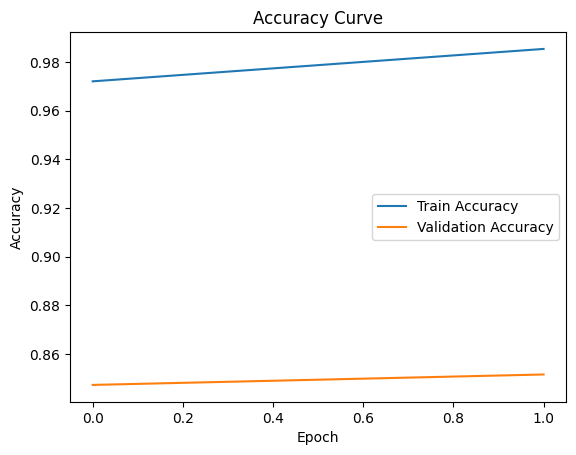

In [ ]:
# Combination 1

learning_rate = 0.001
hidden_size = 100
num_layers = 1
dropout_rate = 0.2
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model1 = train_rnn_network("LSTM", lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)


Epoch 1; Loss 0.245561; Train Acc 0.959143; Val Acc 0.761674
Epoch 2; Loss 0.076850; Train Acc 0.972965; Val Acc 0.777118
Total time elapsed: 494.34 seconds


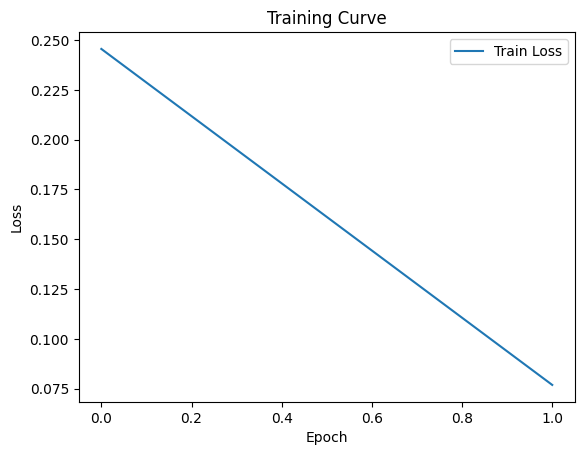

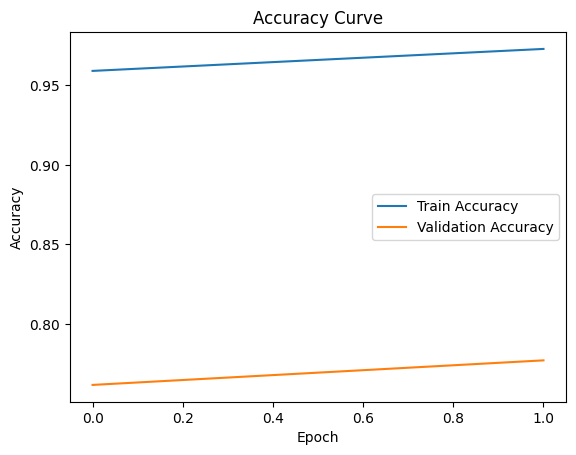

In [ ]:
# Combination 2

learning_rate = 0.001
hidden_size = 50
num_layers = 2
dropout_rate = 0.2
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model2 = train_rnn_network("LSTM", lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)

Epoch 1; Loss 0.225710; Train Acc 0.961426; Val Acc 0.803436
Epoch 2; Loss 0.064972; Train Acc 0.978384; Val Acc 0.761857
Total time elapsed: 258.66 seconds


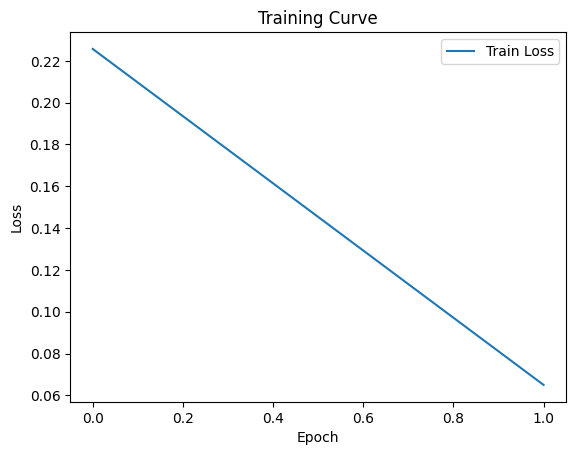

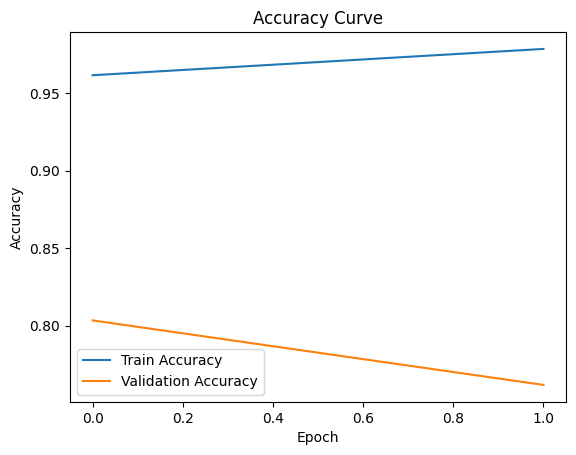

In [ ]:
#Combination 3

learning_rate = 0.001
hidden_size = 50
num_layers = 1
dropout_rate = 0.3
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model3=train_rnn_network("LSTM",lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)

Epoch 1; Loss 0.001444; Train Acc 0.999330; Val Acc 0.749612
Epoch 2; Loss 0.000920; Train Acc 0.999543; Val Acc 0.797496
Total time elapsed: 481.61 seconds


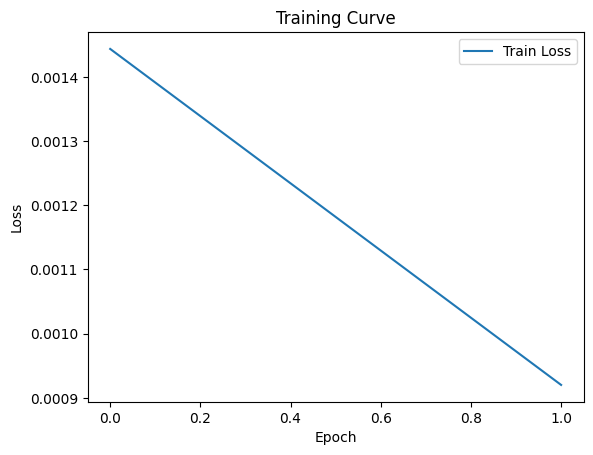

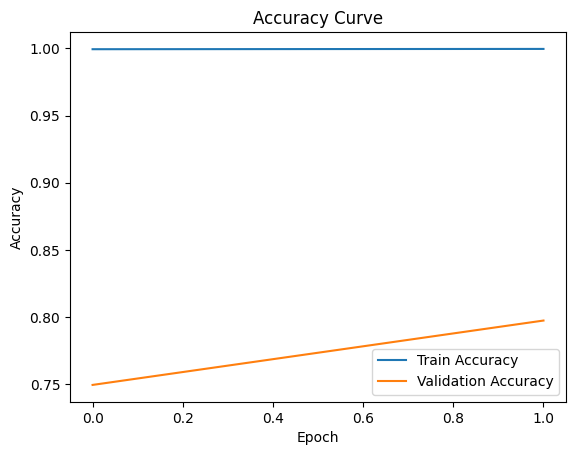

In [ ]:
# Combination 4

learning_rate = 0.001
hidden_size = 100
num_layers = 2
dropout_rate = 0.3
num_epochs = 2
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model4=train_rnn_network("LSTM",lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)

Epoch 1; Loss 0.000551; Train Acc 1.000000; Val Acc 0.794024
Epoch 2; Loss 0.000161; Train Acc 1.000000; Val Acc 0.774833
Total time elapsed: 471.45 seconds


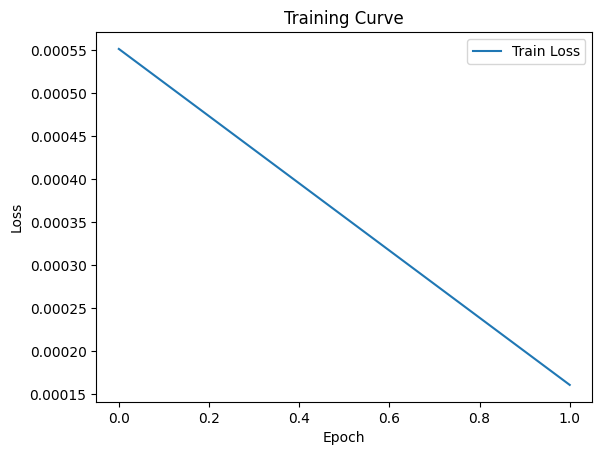

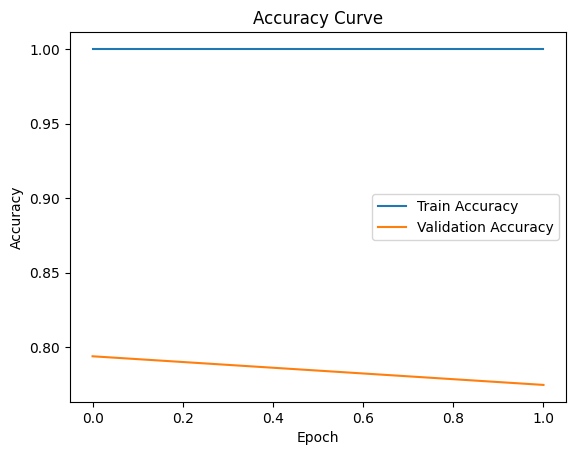

In [ ]:
# Combination 5

learning_rate = 0.0005
hidden_size = 50
num_layers = 1
dropout_rate = 0.2
num_epochs = 2
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model5=train_rnn_network("LSTM",lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)

Epoch 1; Loss 0.213899; Train Acc 0.968672; Val Acc 0.815681
Epoch 2; Loss 0.059446; Train Acc 0.977745; Val Acc 0.776113
Total time elapsed: 347.32 seconds


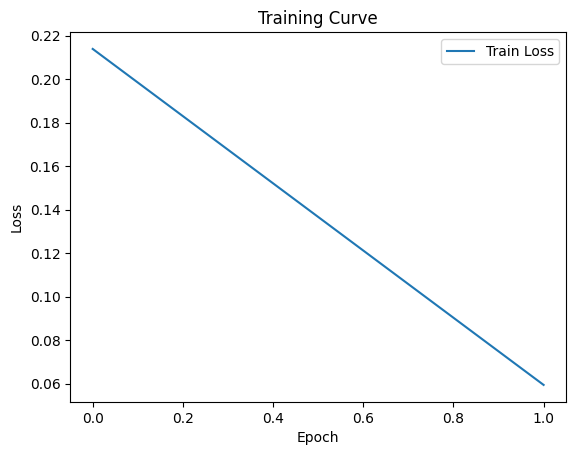

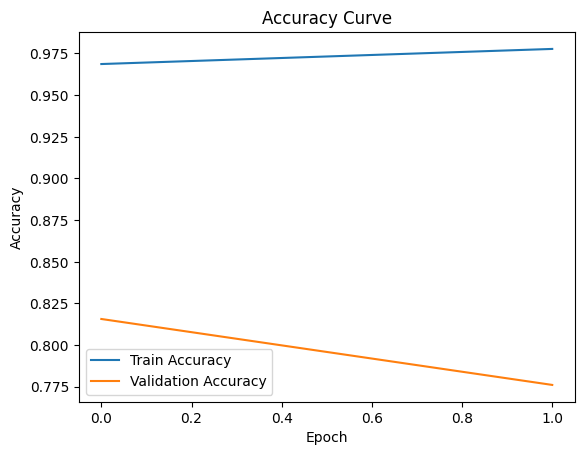

In [ ]:
# Combination 6

learning_rate = 0.001
hidden_size = 50
num_layers = 1
dropout_rate = 0.2
num_epochs = 2
input_size = input_size
num_classes = num_classes
lstm_model = RNN(input_size,hidden_size,num_classes,num_layers, bidirectional)
best_model6=train_rnn_network("LSTM",lstm_model, train_loader, val_loader, num_epochs=2, learning_rate=learning_rate)


## Final Model Testing
Running the testing data through the best model as seen through the validation process. Since Combination 6 showed the best results, this is the model that will be tested.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_list, batch_size=1, shuffle=True)

Since combination 1 had the highest validation accuracy, the same hyperparameters will be used in the final model.

Epoch 1; Loss 0.181227; Train Acc 0.975370; Val Acc 0.802979
Total time elapsed: 371.23 seconds


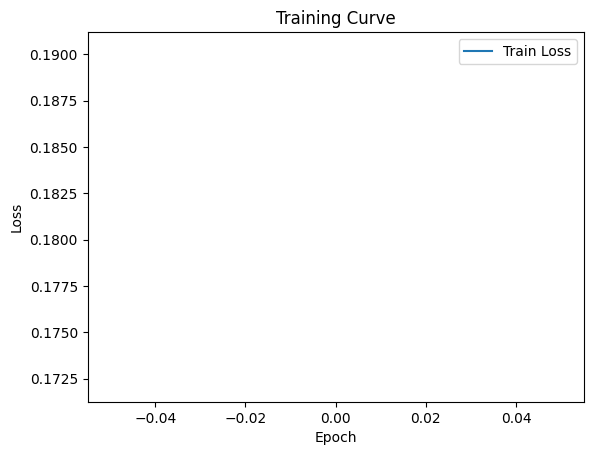

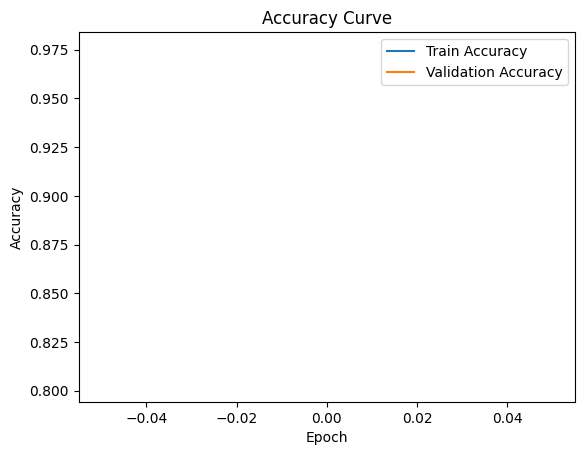

RNN(
  (emb): Embedding(400000, 50)
  (rnn): LSTM(50, 100, batch_first=True)
  (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
final_model = RNN(input_size=50,hidden_size=100,num_class=2,num_layers=1, bidirectional=False)
final_model.dropout_rate = 0.2
train_rnn_network("FinalLSTM",final_model, train_loader, val_loader, num_epochs=1, learning_rate=0.001)

In [ ]:
def evaluate_model_on_test_data(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for text, labels in test_loader:
            outputs = model(text)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    # print('Test Accuracy: {:.2f}%'.format(accuracy))

    return accuracy

In [ ]:
test_acc=(evaluate_model_on_test_data(final_model, test_loader))
print("Test Accuracy: {:.4f}".format(test_acc))

Test Accuracy: 0.8649


# Demo

Demonstration of the model in a mode with UI elements.

In [ ]:
pip install ipywidgets

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import torch.nn as nn
from torchtext.vocab import GloVe

In [ ]:
default_model = RNN(input_size=50, hidden_size=100, num_class=2, num_layers=1, bidirectional=False)
default_model.load_state_dict(torch.load("/content/default_model.pth"))
default_model.eval()

RNN(
  (emb): Embedding(400000, 50)
  (rnn): LSTM(50, 100, batch_first=True)
  (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
final_model = RNN(input_size=50, hidden_size=100, num_class=2, num_layers=1, bidirectional=False)
final_model.load_state_dict(torch.load("/content/final_model.pth"))
final_model.eval()

RNN(
  (emb): Embedding(400000, 50)
  (rnn): LSTM(50, 100, batch_first=True)
  (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
def remove_nonwanted_characters(string_input):

  characters_allowed = "abcdefghijklmnopqrstuvwxyz' "

  #if we want to remove the '
  #characters_allowed = "abcdefghijklmnopqrstuvwxyz "

  return ''.join(character for character in string_input if character in characters_allowed)

In [ ]:
def clean_input(input):
  input = input.lower()
  input = remove_nonwanted_characters(input)
  return input

In [ ]:
model_selector = widgets.Dropdown(
    options={'Default Model': default_model, 'Final Model': final_model},
    value=final_model,
    description='Model:',
    disabled=False,
)

text_input = widgets.Textarea(
    placeholder='Type the text...',
    description='Input:',
    disabled=False,
    layout=widgets.Layout(width='500px', height='200px')
)


analyze_button = widgets.Button(
    description='Analyze',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger'
    tooltip='Click to analyze the text',
    icon='check'
)


output = widgets.Output()


def analyze_text(b):
    with output:
        clear_output()
        input_text = text_input.value
        input_text = clean_input(input_text)
        selected_model = model_selector.value
        idxs = [glove.stoi[w] for w in input_text.split() if w in glove.stoi]
        if not idxs:
            print("No valid text.")
            return
        idxs = torch.tensor(idxs).unsqueeze(0)
        with torch.no_grad():
            prediction = selected_model(idxs)
            predicted_class = torch.argmax(prediction, dim=1).item()
            confidence = torch.softmax(prediction, dim=1).max().item() * 100

            if predicted_class == 1:
                print(f"AI generated text. (Accuracy: {confidence:.2f}%)")
            else:
                print(f"Human Wrote this text. (Accuracy: {confidence:.2f}%)")


analyze_button.on_click(analyze_text)


display(model_selector, text_input, analyze_button, output)


Dropdown(description='Model:', index=1, options={'Default Model': RNN(
  (emb): Embedding(400000, 50)
  (rnn):…

Textarea(value='', description='Input:', layout=Layout(height='200px', width='500px'), placeholder='Type the t…

Button(button_style='success', description='Analyze', icon='check', style=ButtonStyle(), tooltip='Click to ana…

Output()